In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import Image

%matplotlib inline

DATA_RAW_PATH = os.path.abspath(os.path.join(
    os.getcwd(), "../data/raw"))
DATA_OUTPUT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../data/output"))
MODELS_PATH = os.path.abspath(os.path.join(
    os.getcwd(), "../models"))

# To get the example images that below worked on please first run the download_assets.py file

### TensorFlow Object Detection Setup Guide (SSD MobileNet v2)

This guide explains how to manually set up the SSD MobileNet v2 object detection model using OpenCV's DNN module.


#### 1. Download Pre-trained Model

Go to the [TensorFlow Object Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) and download a model trained on the COCO dataset.

Recommended model:
[ssd_mobilenet_v2_coco_2018_03_29.tar.gz](http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz)


#### 2. Extract and Organize the Model Files

After downloading:

- Extract the `.tar.gz` file
- Move the extracted folder to a directory named `models/`

The extracted folder should contain:

```html
models/
└── ssd_mobilenet_v2_coco_2018_03_29
    ├── checkpoint
    ├── frozen_inference_graph.pb
    ├── model.ckpt.data-00000-of-00001
    ├── model.ckpt.index
    ├── model.ckpt.meta
    ├── pipeline.config
    └── saved_model/
```

The main file used for OpenCV inference is `frozen_inference_graph.pb`.

#### 3. Generate Config (.pbtxt) File for OpenCV

OpenCV requires a `.pbtxt` configuration file to understand the model's structure.

To generate it, run the following command using the provided script:

```bash
python tf_text_graph_ssd.py \
  --input models/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb \
  --config models/ssd_mobilenet_v2_coco_2018_03_29.pbtxt
```

If you do not have the script, download it from the official OpenCV repository:

https://github.com/opencv/opencv/blob/master/samples/dnn/tf_text_graph_ssd.py

#### 4. Final Project Structure

Your final directory structure should look like:

```html
project-root/
├── coco_class_labels.txt         # Optional: for displaying class names
├── tf_text_graph_ssd.py          # Script to convert .pb to .pbtxt
├── tf_text_graph_common.py       # Helper script for tf_text_graph_ssd.py file
└── models/
    ├── ssd_mobilenet_v2_coco_2018_03_29/
    │   └── frozen_inference_graph.pb
    └── ssd_mobilenet_v2_coco_2018_03_29.pbtxt
```

#### Check Class Labels

In [2]:
class_file_path  = "../coco_class_labels.txt"

with open(class_file_path) as fp:
    class_labels = fp.read().split("\n")
    
print(class_labels)

['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush', '']


**The steps for performing inferenece using a DNN model are summarized below:**
    
1. Load the model and input image into memory.
2. Detect objects using a forward pass through the network.
3. Display the detected objects with bounding boxes and class labels.

In [3]:
model_file = f"{MODELS_PATH}/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb"
config_file = f"{MODELS_PATH}/ssd_mobilenet_v2_coco.pbtxt"

# Read the Tensorflow network
net = cv2.dnn.readNetFromTensorflow(model=model_file, config=config_file)

In [4]:
def detect_objects(net, img, dim = 300):
    blob = cv2.dnn.blobFromImage(img, 1.0, (dim, dim), mean=(0, 0, 0), swapRB=True, crop=False)
    
    # Pass blob to the network
    net.setInput(blob)
    
    # Peform Prediction
    objects = net.forward()
    return objects

In [5]:
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

In [6]:
def display_text(img, text, x, y):
    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    label_size, baseline = textSize

    cv2.rectangle(img,
                  (x - 5, y - label_size[1] - 5),
                  (x + label_size[0] + 5, y + 5),
                  (0, 0, 0),
                  cv2.FILLED
    )

    cv2.putText(img,
                text, (x, y - 5),
                FONTFACE,
                FONT_SCALE,
                (0, 255, 255),
                THICKNESS,
                cv2.LINE_AA,
    )

**detections.shape = (1, 1, N, 7)**

Where:
- 1 is the batch size (we’re only using 1 image at a time)
- 1 is a technical placeholder (legacy from TensorFlow model export)
- N is the number of detected objects (could vary per image)
- 7 is the size of the data for each detection
    - [0] - Image ID (always 0 since batch size is 1)
    - [1] - Class ID (integer index of the detected class, e.g., 1 = person)
    - [2] - Confidence (score between 0 and 1, higher means more confident)
    - [3] - xmin (normalized left boundary of bounding box: 0.0 - 1.0)
    - [4] - ymin (normalized top boundary)
    - [5] - xmax (normalized right boundary)
    - [6] - ymax (normalized bottom boundary)

In [7]:
def display_objects(img, objects, threshold=0.25):
    rows = img.shape[0]
    cols = img.shape[1]
    
    for i in range(objects.shape[2]):
        classId = int(objects[0, 0, i, 1])
        confidense =  objects[0, 0, i, 2]
        
        left_x = int(objects[0, 0, i, 3] * cols)
        top_y = int(objects[0, 0, i, 4] * rows)
        right_x = int(objects[0, 0, i, 5] * cols)
        bottom_y = int(objects[0, 0, i, 6] * rows)
        
        if confidense > threshold:
            display_text(img, f"{class_labels[classId]}", left_x, top_y)
            cv2.rectangle(img, (left_x, top_y), (right_x, bottom_y), (255, 255, 255), 2)
            
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(30, 10))
    plt.imshow(img_rgb)
    plt.show()

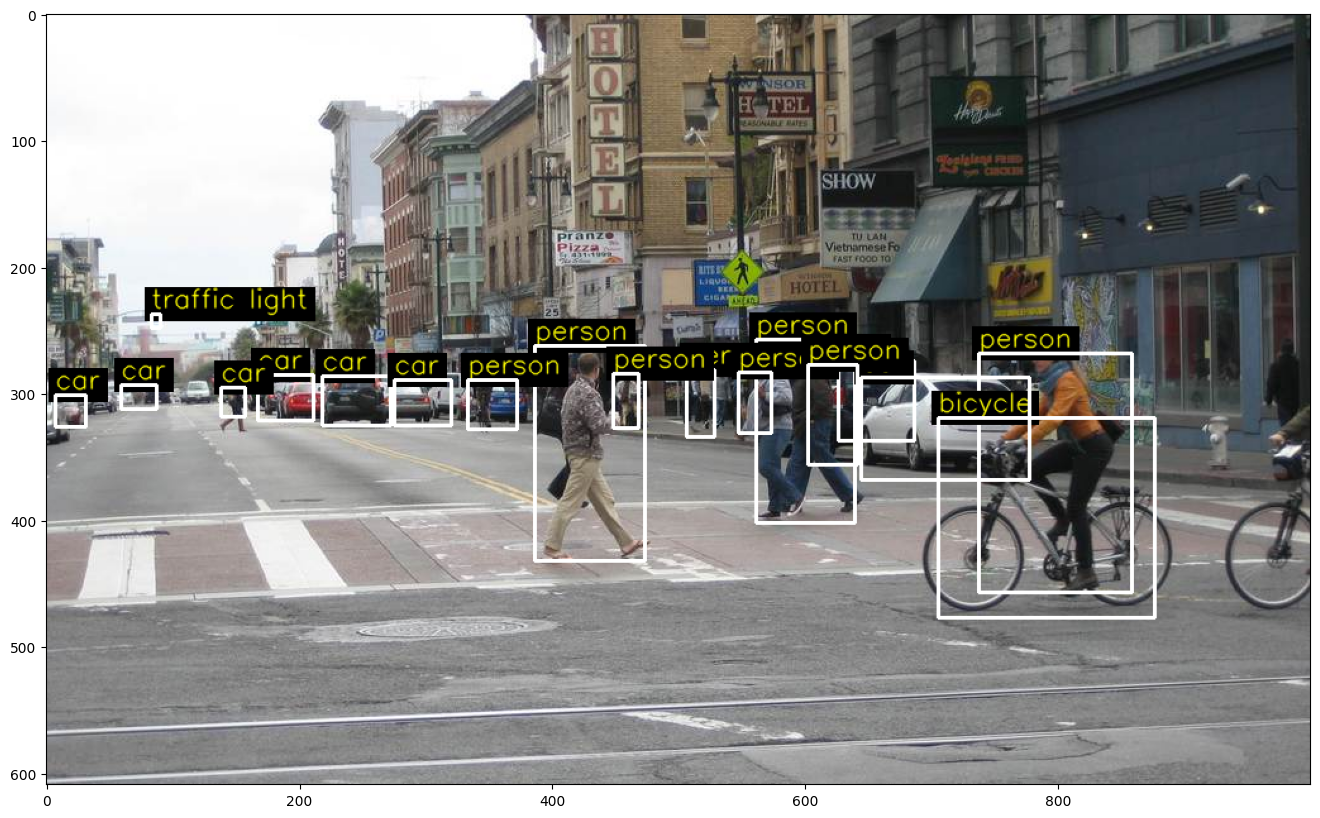

In [8]:
img_path = f"{DATA_RAW_PATH}/images/street.jpg"

img = cv2.imread(img_path, cv2.IMREAD_COLOR)
objects = detect_objects(net, img)
display_objects(img, objects)

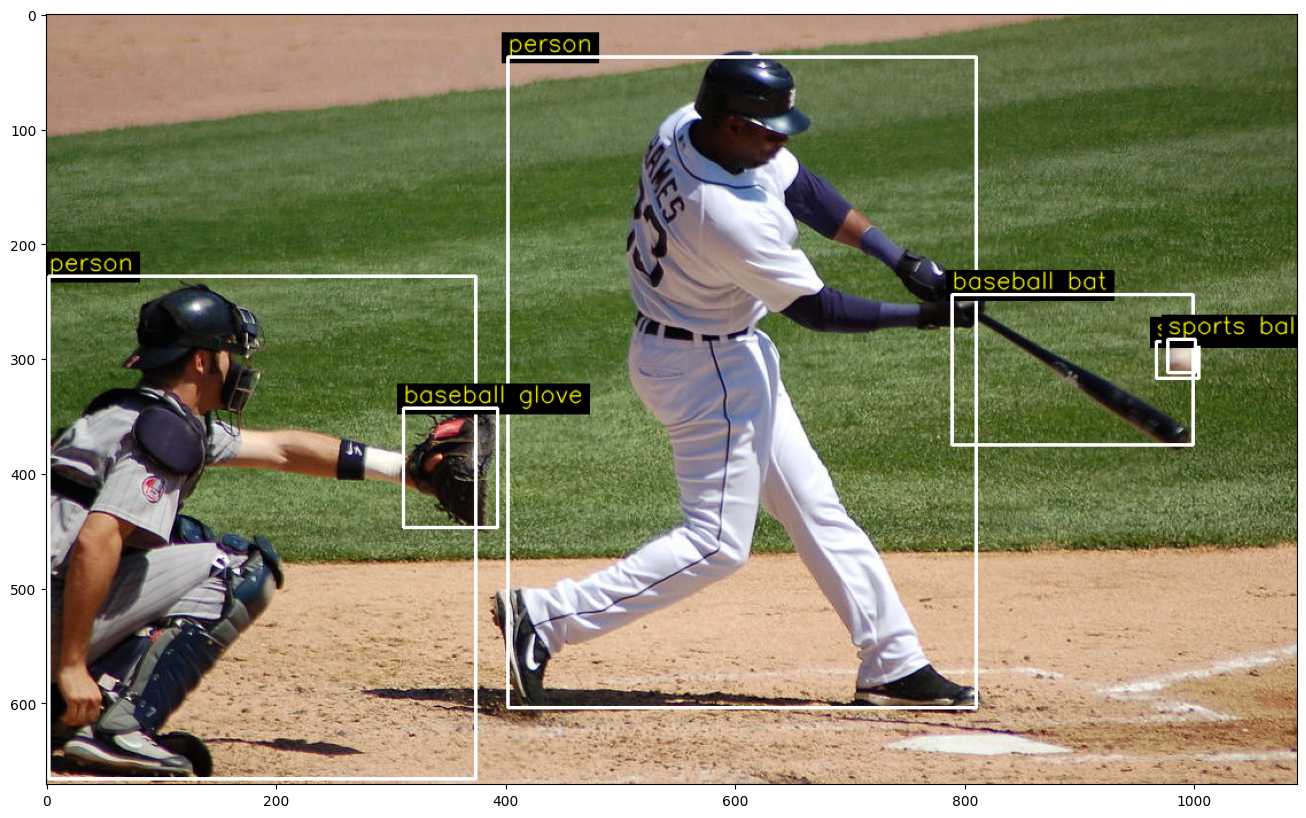

In [9]:
img_path = f"{DATA_RAW_PATH}/images/baseball.jpg"

img = cv2.imread(img_path, cv2.IMREAD_COLOR)
objects = detect_objects(net, img)
display_objects(img, objects)

In [10]:
img_path = f"{DATA_RAW_PATH}/images/soccer.jpg"

img = cv2.imread(img_path, cv2.IMREAD_COLOR)
objects = detect_objects(net, img)
display_objects(img, objects)